In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/My Drive/Deep Learning Projects/Review prediction/')

Mounted at /content/drive


## Packages

In [ ]:
pip install evaluate

In [ ]:
pip install contractions

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from bert.model import bert
from bert.bert_training import train_loop
from bert.bert_training import eval_loop
from bert.bert_training import early_stopping
from bert.configs import config
from utils import utils

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from contractions import fix

from datasets import load_dataset
from collections import Counter

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Exploration



In [ ]:
def load_data(path):
  """
  Load and preparation of data
  """
  # load data from Hugging Face datasets
  ds = load_dataset(path)

  # convert datasets to pandas dataframe
  for split in ds.keys():
    df = ds[split].to_pandas()
    df.to_csv(f'{split}.csv', index=False)

  # extract train/test sets
  train = pd.read_csv('/content/train.csv')
  test = pd.read_csv('/content/test.csv')

  return ds, train, test

In [ ]:
# load the data
dataset, df_train, df_test = load_data("Yelp/yelp_review_full")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df_train

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...
649996,0,Phone calls always go to voicemail and message...
649997,0,Looks like all of the good reviews have gone t...
649998,4,I was able to once again rely on Yelp to provi...


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   650000 non-null  int64 
 1   text    650000 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.9+ MB


In [ ]:
df_train.describe()

,label
count,650000.000000
mean,2.000000
std,1.414215
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [ ]:
df_train.isnull().sum()

,0
label,0
text,0


## Preprocessing

In [ ]:
def text_preprocessing(text):
    # Expand contractions
    text = fix(text)

    # Lowercase text
    text = text.lower()

    # Remove weird characters
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\s]", " ", text)

    # Remove multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
df_train['text'] = df_train['text'].apply(text_preprocessing)
df_test['text'] = df_test['text'].apply(text_preprocessing)

df_train.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"unfortunately, the frustration of being dr. go..."
2,3,been going to dr. goldberg for over 10 years. ...
3,3,got a letter in the mail last week that said d...
4,0,i do not know what dr. goldberg was like befor...


## Data Analysis

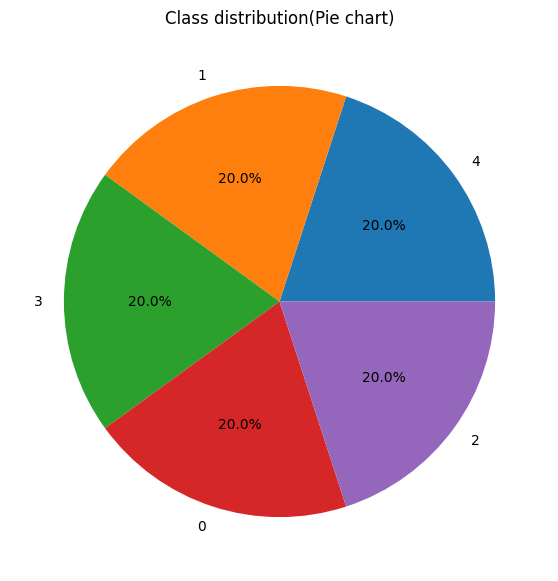

In [ ]:
# categories
categories = df_train['label'].value_counts()

plt.figure(figsize=(7, 7))
plt.title('Class distribution(Pie chart)')
plt.pie(categories, labels=list(categories.index), autopct="%.1f%%")
plt.show()

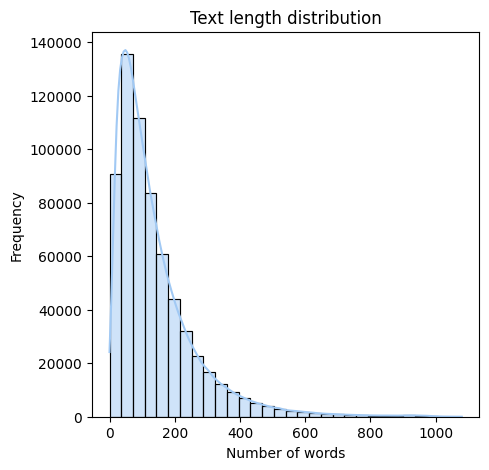

In [ ]:
# Analyze length distribution
df_train["text_len"] = df_train['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(5, 5))
sns.set_palette("pastel")
sns.histplot(df_train['text_len'], bins=30, kde=True)
plt.title("Text length distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

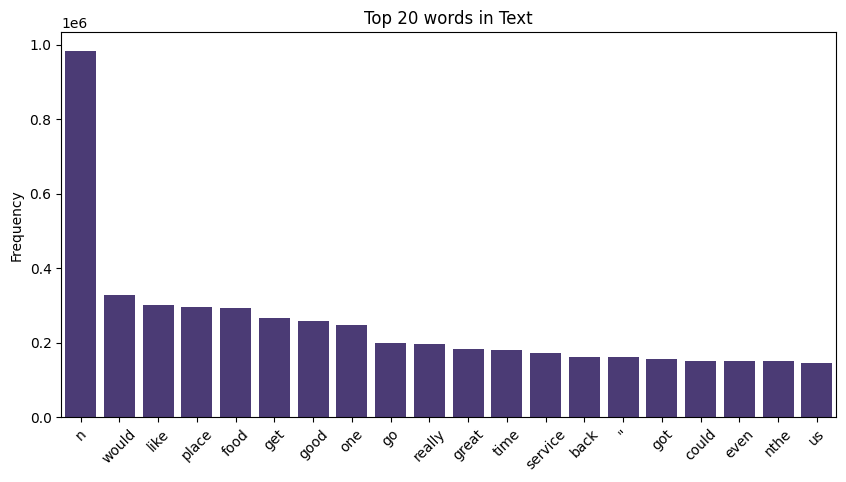

In [ ]:
# top 20 words in text

sns.set_palette('viridis')
stop_words = set(stopwords.words('english'))
word_counter = Counter()

for item in df_train['text']:
    words = [w for w in item.split() if w not in stop_words]
    word_counter.update(words)

top_20 = word_counter.most_common(20)

words, counts = zip(*top_20)

plt.figure(figsize=(10,5))
sns.barplot(x=words, y=counts)
plt.title("Top 20 words in Text")
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

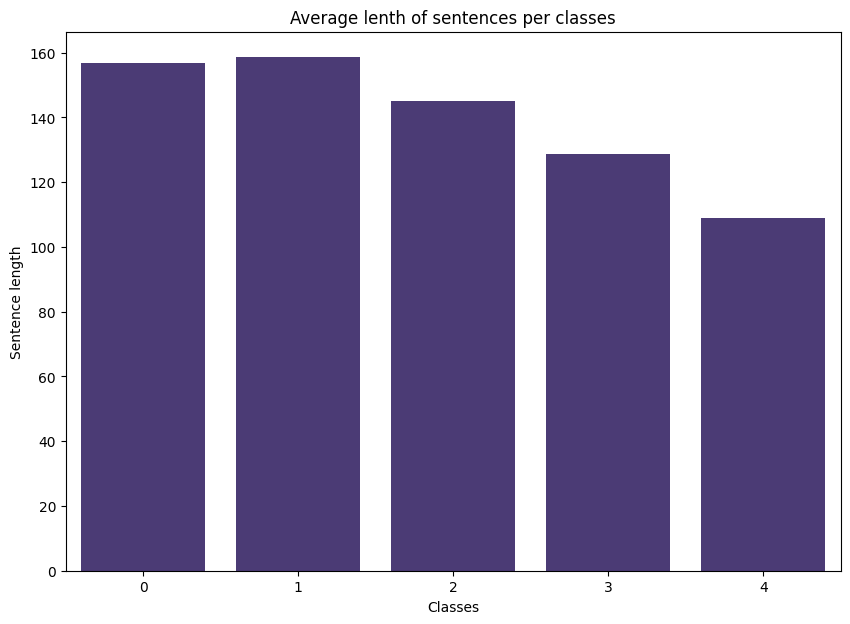

In [ ]:
avg_length = df_train.groupby('label')['text_len'].mean().reset_index()

plt.figure(figsize=(10, 7))
sns.barplot(x='label', y='text_len', data=avg_length)
plt.title("Average lenth of sentences per classes")
plt.xlabel('Classes')
plt.ylabel("Sentence length")
plt.show()

## Tokenization

In [ ]:
# Initialize BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize sample text
text = "I like build ML model from scratch"
tokens = tokenizer(text, padding='max_length', truncation=True, max_length=256)

print(tokens)

{'input_ids': [101, 1045, 2066, 3857, 19875, 2944, 2013, 11969, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Fine-tune Pre-trained BERT

### Tokenization with BERT

In [ ]:
def tokenizer_func(batch):
    return tokenizer(
        batch['text'],
        padding="max_length",
        truncation=True,
        max_length=256,
    )

In [ ]:
# Apply the tokenizer to dataset
tokenized_dataset = dataset.map(tokenizer_func, batched=True)

# Inspect tokenized samples
print(tokenized_dataset["train"][0])

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.", 'input_ids': [101, 2852, 1012, 18522, 4107, 2673, 1045, 2298, 2005, 1999, 1037, 2236, 18742, 1012, 2002, 1005, 1055, 3835, 1998, 3733, 2000, 2831, 2000, 2302, 2108, 9161, 6026, 1025, 2002, 1005, 1055, 2467, 2006, 2051, 1999, 3773, 2010, 5022, 1025, 2002, 1005, 1055, 6989, 2007, 1037, 2327, 1011, 18624, 2902, 1006, 27935, 1007, 2029, 2026, 3008, 2031, 4541, 2000, 2033, 2003, 2200, 2590, 1999, 2553, 2242, 6433, 1998, 2017, 2342, 5970, 1025

### Check class imbalance

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

labels = dataset["train"]["label"]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
print(class_weights)

[1. 1. 1. 1. 1.]


### Model Selection and Configuration

In [ ]:
from transformers import AutoModelForSequenceClassification

# Initialize BERT model for multi-class classification
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

print(model.config)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



### Freezing Layers

In [ ]:
# # Freeze all layers except the classifier
# for param in model.deberta.parameters():
#     param.requires_grad = False

# # Keep only the classification head trainable
# for param in model.classifier.parameters():
#     param.requires_grad = True


print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 109486085


### Extend BERT Architecture

In [ ]:
from transformers import AutoModel

class CustomBERTModel(torch.nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name, num_labels=num_labels)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(output.last_hidden_state[:, 0, :])
        logits = self.fc(pooled_output)

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

        return {"logits": logits}


# Initialize custom model
custom_model = CustomBERTModel('bert-base-uncased', num_labels=5)

### Training Pipeline

In [ ]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    gradient_accumulation_steps = 4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    lr_scheduler_type="linear",
    metric_for_best_model="accuracy",
    warmup_ratio=0.1,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,
    report_to="none"
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import Trainer
from evaluate import load
from sklearn.metrics import accuracy_score, f1_score


metric = load("f1")

# define custom metric function
def compute_metric(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")  # or "macro"

    return {
        "accuracy": acc,
        "f1": f1
    }

In [ ]:
from transformers import EarlyStoppingCallback, get_scheduler


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metric,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


# start training
trainer.train()

/tmp/ipython-input-784999510.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.718400,0.736627,0.678120,0.675273
2,0.646500,0.722326,0.686040,0.686953
3,0.587400,0.744210,0.685320,0.684203


TrainOutput(global_step=30471, training_loss=0.6576039567562864, metrics={'train_runtime': 12723.4541, 'train_samples_per_second': 153.26, 'train_steps_per_second': 2.395, 'total_flos': 2.565401889024e+17, 'train_loss': 0.6576039567562864, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Generate predictions
predictions = trainer.predict(tokenized_dataset["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_dataset["test"]["label"], predicted_labels))


# Confusion matrix
cm = confusion_matrix(tokenized_dataset["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1", "2", "3", "4"])
disp.plot()


# BERT from scratch

## Create dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=config.MAX_LEN):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask = encoded["attention_mask"].squeeze(0)

        segment_ids = torch.zeros_like(input_ids)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "segment_ids": segment_ids,
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
train_dataset = CustomDataset(
    df_train['text'],
    df_train['label'],
    tokenizer,
    max_len=config.MAX_LEN
)

test_dataset = CustomDataset(
    df_test['text'],
    df_test['label'],
    tokenizer,
    max_len=config.MAX_LEN
)

In [ ]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=True,
                              num_workers=4,
                              pin_memory=True,
                              prefetch_factor=2,
                              persistent_workers=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=4,
                             pin_memory=True,
                             prefetch_factor=2,
                             persistent_workers=True)

### Create training loop

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5,
          patience=5,
          scheduler=None):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    early_stopper = early_stopping.EarlyStopping(patience=patience)

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_loop.train_step(model=model,
                                                      dataloader=train_dataloader,
                                                      loss_fn=loss_fn,
                                                      optimizer=optimizer,
                                                      device=device,
                                                      scheduler=scheduler)

        test_loss, test_acc = eval_loop.test_step(model=model,
                                                  dataloader=test_dataloader,
                                                  loss_fn=loss_fn,
                                                  device=device)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        # Early stopping check
        early_stopper(test_loss)

        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # 6. Return the filled results at the end of the epochs
    return results

### Set BERT Model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# vocab_size
vocab_size = tokenizer.vocab_size


# Initialize model
bert_model = bert.BERTClassfier(
    vocab_size=vocab_size,
    num_classes=5,
    d_model=config.D_MODEL,
    n_layers=config.N_LAYERS,
    num_heads=config.NUM_HEADS,
    seq_len=config.MAX_LEN
).to(device)
torch.compile(bert_model)

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = bert_model.configure_optimizers(weight_decay=0.1, learning_rate=config.LR)
num_training_steps = len(train_dataloader) * config.EPOCHS
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

bert_model_result = train(bert_model,
                          train_dataloader,
                          test_dataloader,
                          optimizer,
                          loss_fn,
                          config.EPOCHS,
                          scheduler=scheduler)

num decayed parameter tensors: 473, with 109,167,360 parameters
num non-decayed parameter tensors: 88, with 94,469 parameters
using fused AdamW: True


  0%|          | 0/3 [00:00<?, ?it/s]

/content/drive/My Drive/Deep Learning Projects/News Topics Classification/bert/bert_training/train_loop.py:62: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  norm = torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)


Epoch: 1 | train_loss: 0.2929 | train_acc: 0.4777 | test_loss: 0.9999 | test_acc: 0.5640
Epoch: 2 | train_loss: 0.2378 | train_acc: 0.5830 | test_loss: 0.9869 | test_acc: 0.5767
Epoch: 3 | train_loss: 0.2248 | train_acc: 0.6086 | test_loss: 0.9453 | test_acc: 0.5871


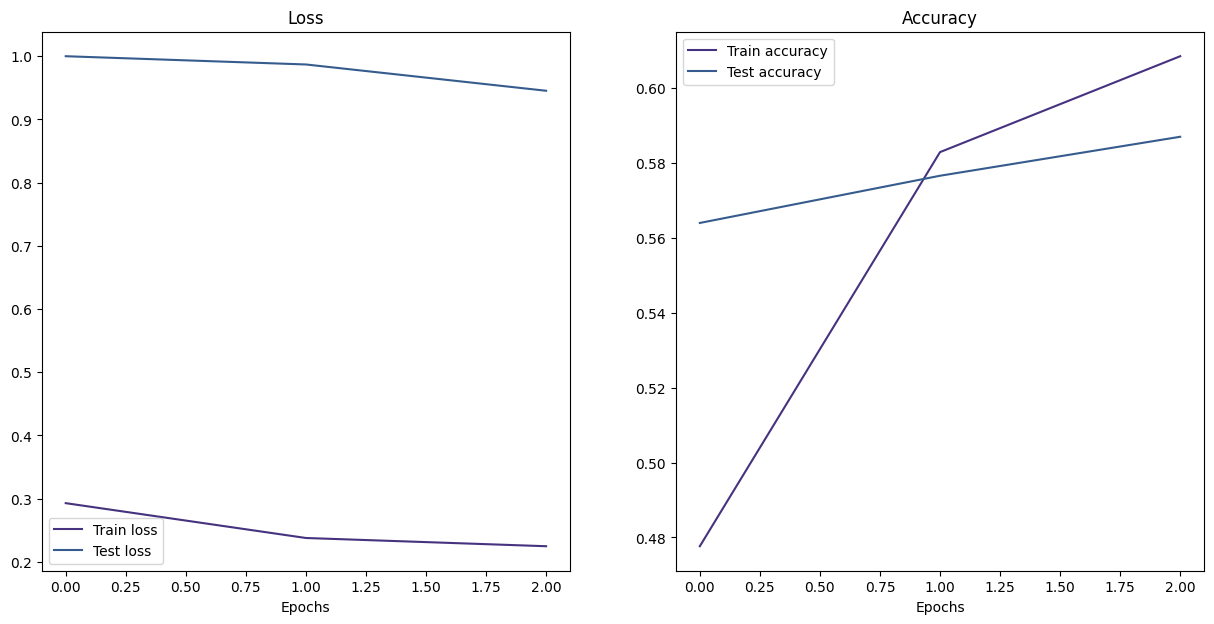

In [ ]:
# visualize loss and accuracy
utils.plot_loss_curves(bert_model_result)